# Settings

In this section, we will set up some parmeters for this project like importing libraries and directories

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

base_dir = "MyDrive/COMPUTER VISION/ASSIGNMENT 2/"

Mounted at /content/gdrive


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import random_split, DataLoader
from torchvision import models
import time
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import torchvision.models as models

from torch.optim import SGD
!pip install torchmetrics
!pip install imageio[pyav]
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image
import os

import cv2
import imageio.v2 as imageio
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 50.9 MB/s eta 0:00:00


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 1. Classification with transfer learning

In thisn exercise, we will use transfer learning to train a classification model. The model used is VGG-16.

VGG16, as its name suggests, is a 16-layer deep neural network. VGG16 is thus a relatively extensive network with a total of 138 million parameters.

A VGG network consists of small convolution filters. VGG16 has three fully connected layers and 13 convolutional layers.

Here is a quick outline of the VGG architecture:

* Input: VGG16 receives a 224×224 image input.
* Convolutional layers: the convolutional filters of VGG use the smallest possible receptive field of 3×3. VGG also uses a 1×1 convolution filter as the input's linear transformation.
* RLu activation : next is the Rectified Linear Unit Activation Function (ReLU) component, AlexNet's major innovation for reducing training time. ReLU is a linear function that provides a matching output for positive inputs and outputs zero for negative inputs. VGG has a set convolution stride of 1 pixel to preserve the spatial resolution after convolution (the stride value reflects how many pixels the filter "moves" to cover the entire space of the image).
* Hidden layers : all the VGG network's hidden layers use ReLU instead of Local Response Normalization like AlexNet. The latter increases training time and memory consumption with little improvement to overall accuracy.
* Pooling layers : A pooling layer follows several convolutional layers (this helps reduce the dimensionality and the number of parameters of the feature maps created by each convolution step). Pooling is crucial given the rapid growth of the number of available filters from 64 to 128, 256, and eventually 512 in the final layers.
* Fully connected layers : VGGNet includes three fully connected layers. The first two layers each have 4096 channels, and the third layer has 1000 channels, one for every class.

In order, we will:
* Loadthe dataset CIFAR10 and split it in train, test and validation set
* Display some images
* Train the old model with a CNN (assignment 1)
* Train a new model with transfer learning
* Compare these models about accuracy and training times

## Data loading
As VGG16 has been trained on ImageNet datasets, the model expects an image of size 3x224x224. However, CIFAR10 images have a siez of 3x32x32. it is therefore necessary to increase the size of these images to 3x224x224.

When resizing, an interpolation method is often used to determine the pixel values in the new image. By default, the bilinear interpolation method is often used. This means that pixel values in the resized image are calculated using linear interpolation between neighboring pixels in the original image.

This method can be explained as follows:
* Step 1 - Calculate $ \Delta_x = \frac{32}{224} $
* Step 2 -Calculate each $ x_k $ such that $ x_k = (k+0.5)\Delta_x - 0.5 $ for $ k\in[0,224)$
* Step 3- Take a layer of an origin image as an array $A$ and the output layer is $O$.
* Step 4- The first and last column of A is replicated in $O$.
* Step 5 - For each values of $n\in[1,223)$ (index of columns of A without the first and the last) do:
  - Calculate the weighs $w_0 = 1-x_n$ and $w_1 = 1-w_0$
  - $ O[line,n] = A[line, n-1]\times w_0 + A[line, n]\times w_2 $
* Step 6- Repeat Sptep 4 to 5 for each $line$
* Step 7 Repeat step 2 to 6 for until have a size 224x224
* Step 8 - Repeat step 2 to 7 for each layer of three

this method has been computed in the function transforms.Resize() as following


In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

data_train = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

validation_size = 1000

train_size = len(data_train) - validation_size
train_dataset, validation_dataset = random_split(data_train, [train_size, validation_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)

valid_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
classes = ['plane','car','bird','cat','deer','dog','frog','horse','ship','truck']

Now, let us visualize some images.

In [ ]:
def show_images(images, labels):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))

    trans = transforms.ToPILImage()
    for i in range(len(images)):
        img = images[i]
        img = np.transpose(img.numpy(), (1, 2, 0))
        axs[i].imshow(img)
        axs[i].set_title(classes[labels[i]]+", Shape: "+ str(images[i].shape), fontsize=10)
        axs[i].axis('off')
    plt.show()

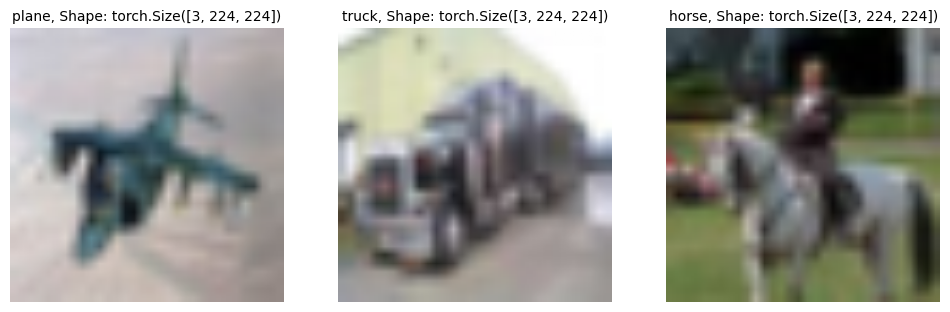

In [ ]:
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=3, shuffle=True)
dataiter = iter(data_loader)
images, labels = next(dataiter)
show_images(images, labels)

## Getting results of the old model (Assignment 1)
In this section, we will run the first model to get the results: accuracy on test set and training time

In [ ]:
transform_old = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

full_dataset_old = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_sampler_old = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

valid_sampler_old,train_sampler_old = torch.utils.data.random_split(full_dataset_old, [len(test_sampler_old), len(full_dataset_old)-len(test_sampler_old)])

train_loader_old = torch.utils.data.DataLoader(train_sampler_old, batch_size=64, shuffle=True, num_workers=2)

valid_loader_old = torch.utils.data.DataLoader(valid_sampler_old, batch_size=64, shuffle=True, num_workers=2)
test_loader_old = torch.utils.data.DataLoader(test_sampler_old, batch_size=64, shuffle=False, num_workers=2)

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(200704, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

CNN_model = Model()

CNN_model = CNN_model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = optim.Adam(CNN_model.parameters(), lr=0.001)

def calculate_accuracy(dataloader, model, device):
  correct = 0
  total = 0
  with torch.no_grad():
    softmax = nn.Softmax(dim=1)
    for data in dataloader:
          images, labels = data
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          probabilities = F.softmax(outputs, dim=1)
          predicted = torch.argmax(probabilities, dim=1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  accuracy = 100 * correct / total
  return accuracy

CNN_model.eval()
num_epochs = 5

t1 = time.time()
for epoch in tqdm(range(num_epochs), desc="Training model..."):
  for i, data in enumerate(train_loader_old):

    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    outputs = CNN_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
t2 = time.time()
accuracy = calculate_accuracy(test_loader_old, CNN_model, device)
print('Accuracy on test set: '+ str(accuracy)+'%')
print('Training time :'+str(t2-t1)+' s')

Files already downloaded and verified
Files already downloaded and verified


Training model...: 100%|██████████| 5/5 [06:11<00:00, 74.26s/it]


Accuracy on test set: 41.43%
Training time :371.3026599884033 s


## Model with transfer learning

Basically, transfer leaning is reuse pretrained model on a new problem. So, a machine exploits the knowledge gained from a previous task to improve generalization about another.

In details, we will add a hidden fully connected layer of 2*4096 to VGG16 and reduce the output layer at size 10. The steps to follow are below:
* Load pre-trained VGG16 model
* Modify the classifier part
* Freeze the weights of the feature extraction layers
* Training the model
* Evaluating of the model

In [ ]:
# Step 1: Load pre-trained VGG16 model
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)
# Step 2: Modify the classifier part with our custom layers
custom_classifier = nn.Sequential(
    nn.Linear(in_features=25088, out_features=4096, bias=True),
    nn.ReLU(),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(in_features=4096, out_features=2*4096, bias=True),
    nn.ReLU(inplace=True),
    nn.Dropout(p=0.5, inplace=False),
    nn.Linear(2*4096, 10)
)
custom_classifier.to(device)
vgg16.classifier = custom_classifier

# Step 3: Freeze the weights of the feature extraction layers
for param in vgg16.features.parameters():
    param.requires_grad = False

# Step 4: Prepare training
vgg16 = vgg16.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = SGD(vgg16.classifier.parameters(), lr=0.001)

In [ ]:
summary(vgg16, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

For this specifications, 136 409 098 should be estimated. Let us do it with 5 epochs:

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

for param in vgg16.classifier.parameters():
    param.requires_grad = True

In [ ]:
num_epochs = 5
t3 = time.time()
for epoch in tqdm(range(num_epochs), desc="Model trainin...:" ):
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        outputs.to(device)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(data_loader)
    epoch_acc = running_corrects.double() / len(train_loader)

t4 = time.time()
print('\nTraining time: '+str(t4-t3)+' s')

Model trainin...:: 100%|██████████| 5/5 [21:54<00:00, 262.93s/it]


Training time: 1314.63813662529 s


In [ ]:
correct = 0
for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        outputs.to(device)
        correct += torch.sum(preds == labels.data)
acc = correct/len(test)

In [ ]:
print('Accuracy on test set: '+str(100*acc.item())+' %')

Accuracy on test set: 64.4599974155426 %


The calculus above give us the training time and the accuracy of each model. Let us compare them in this table

<table>
  <thead>
    <tr>
      <td>Model</td>
      <td>Accuracy on test set</td>
      <td>Time training</td>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Model CNN of assignment 1</td>
      <td>41.43%</td>
      <td>371.30 s</td>
    </tr>
    <tr>
      <td>Model with transfer learning</td>
      <td>64.45%</td>
      <td>1314.64 s</td>
    </tr>
  </tbody>
</table>

This table shows that transfer learning has improved the model's performance and classifies the images better than the standard method. On the other hand, transfer learning slows down model training compared with the standard CNN method.

# 2 - Evaluating an object detection model
In this exercise, the goal is to evaluate the model YOLOv5 on validation VOC Detection datasets.

In order, we will:
* Load the dataset
* Visualize some images
* Load pre-trained YOLOv5 model
* Calculate mAP and interpret it

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

voc_test = torchvision.datasets.VOCDetection(root='gdrive/'+base_dir+"data2/voc", year="2012", image_set="val", transform=transform, download=False)

def custom_collate(batch):
    images, targets = zip(*batch)
    return torch.stack(images, dim=0), targets

test_loader = torch.utils.data.DataLoader(voc_test, batch_size=32,collate_fn=custom_collate, shuffle=False, num_workers=4)

print(f"Lenght of dataset : {len(voc_test)}")

Lenght of dataset : 5823


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


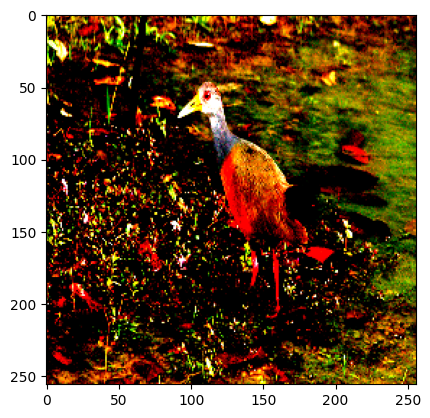

In [ ]:
data_loader = torch.utils.data.DataLoader(voc_test, batch_size=3, shuffle=True, collate_fn=lambda x: x)
dataiter = iter(data_loader)
images, labels, _ = next(dataiter)

plt.imshow(np.transpose(images[0], (1, 2, 0)))
plt.show()
classes = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
            'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

Let's load YOLOv5 like this:

In [ ]:
yolo5 = torch.hub.load('ultralytics/yolov5', 'yolov5s', pretrained=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:294: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
requirements: Ultralytics requirements ['gitpython>=3.1.30', 'Pillow>=10.0.1'] not found, attempting AutoUpdate...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.

The mean Average Precision is a metric used to measure the performance of an object detection model. It compares the actual bounding box with the predicted box of objects and returns a score between 0 and 1. The higher the mAP, the better the model detects the position of objects.

The computation of mAP require some steps:
* get all bounding boxes predicted on the test set
* Compute Precision and Recall for all images :
 - $ Precision=\frac{TP}{TP+FP} $
 - $ Recall = \frac{TP}{FN+TP} $
* Plot the Precision - Recall figure and calculate the area under this curve. This area is called AP (Average Precision)
* Calculate mAP with the formule:
$$
mAP = \frac{1}{n}\sum_{i=1}^{n}AP_{i}
$$

This metric has been computed in Pytorch with the class MeanAveragePrecision() and its method update() allow to update mAP at each iteration

Because of low computing capacity, we will evaluate just 100 first images like this :

In [ ]:
metric = MeanAveragePrecision(iou_type="bbox", box_format='xyxy')

for sample_idx in tqdm(range(100), desc="Model evaluation....:" ):
    img, target = voc_test[sample_idx]
    annotations = target['annotation']['object']
    link ='gdrive/' + base_dir+'data2/voc/VOCdevkit/VOC2012/JPEGImages/'+target['annotation']['filename']

    image = Image.open(link)
    pred = yolo5(link)

    df_preds = pred.pandas().xyxy[0]
    for i in range(len(df_preds)):
        values_pred = list(df_preds.loc[i])
        preds = [
        dict(
            boxes=torch.tensor([values_pred[:4]]),
            scores=torch.tensor([values_pred[4]]),
            labels=torch.tensor([values_pred[5]]),
            )
        ]

        values_targets = [int(x) for x in list(annotations[0]['bndbox'].values())]
        targets = [
        dict(
            boxes=torch.tensor([values_targets]),
            labels=torch.tensor([classes.index(target['annotation']['object'][0]['name'])]),
        )
        ]

        metric.update(preds, targets)
        metric.compute()


Model evaluation....:: 100%|██████████| 100/100 [02:45<00:00,  1.65s/it]


In [ ]:
mAP = metric.compute()['map'].item()
print("VAlue of mAP= "+str(mAP))

VAlue of mAP= 0.0286138616502285


As displayed, the score of simillarity between predicted boundary box and real one is 2.8% and this value is low. The use of VOC dataset instead of COCO dataset may be the reason for this low value.

# 3 - Fully convolutional network for image denoising

In this exercise, the goal is to build a fully convolutional network for image denoising using the coulor version of LFWcrop.

In order, we will:
* Create a class to represent dataset of images faces
* Load datasets and visualize some of them
* Split dataset in train, test and validation set
* Definite the model
* Train the model
* Evaluate the model

Here, ou data class

In [ ]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, transform=None):
        self.data_paths = ['gdrive/'+root_path+f for f in sorted(os.listdir('gdrive/'+root_path))]
        # self.label_paths = [f for f in sorted(os.listdir(root_path)) if f.startswith("label")]
        self.transform = transform

    def __getitem__(self, idx):
        img = imageio.imread(self.data_paths[idx])
        if self.transform:
            img = self.transform(img)
        return img#, label

    def __len__(self):
        return len(self.data_paths)

TRAIN_PATH = base_dir+'data3/lfwcrop_color/faces/'
full_dataset = MyDataset(root_path=TRAIN_PATH, transform=transforms.ToTensor())

Now, let us show some images

In [ ]:
def show_images(images):
    fig, axs = plt.subplots(1, len(images), figsize=(12, 4))
    # axs.figsize((6,6))
    trans = transforms.ToPILImage()
    for i in range(len(images)):
        img = images[i]  + np.random.normal(0, 255, size=(3,64,64))# Unnormalize
        img = np.clip(img, 0, 255)
        img = np.transpose(img.numpy(), (1, 2, 0))  # Reshape for displaying
        axs[i].imshow(img)
        # axs[i].set_title(classes[labels[i]]+", Shape: "+ str(images[i].shape), fontsize=10)
        axs[i].axis('off')
    plt.show()

The following code split randomly the dataset in 3 parts: train, test and validation sets (8:1:1)

In [ ]:
ratio = 0.1
shuffle_dataset = True
random_seed = 42

indices = list(range(len(full_dataset)))
split = int(np.floor(0.1 * len(full_dataset)))

np.random.seed(3333)
np.random.shuffle(indices)

train_size = int(ratio * len(full_dataset))
val_size = int(ratio * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

test_indices, val_indices,  train_indices = np.split(indices, [train_size, train_size + val_size])

train_sampler_true = SubsetRandomSampler(train_indices)
test_sampler_true = SubsetRandomSampler(test_indices)
valid_sampler_true = SubsetRandomSampler(val_indices)

test_sampler_true, valid_sampler_true,train_sampler_true = torch.utils.data.random_split(full_dataset, [train_size, val_size, test_size])

train_loader_true = torch.utils.data.DataLoader(train_sampler_true, batch_size=128, shuffle=True, num_workers=0)
valid_loader_true = torch.utils.data.DataLoader(valid_sampler_true, batch_size=128, shuffle=True, num_workers=0)
test_loader_true = torch.utils.data.DataLoader(test_sampler_true, batch_size=128, shuffle=False, num_workers=0)

For the model, the architecture is followin:
* encoder sequential:
 - two layers with the same number of neurons
 - kernel_size = 3
 - padding = 1
 - Relu function as activator
 - A MAx pooling with kernel size 2 and sride 2
* For decoding, we will use ConvTranspose2d in the deconvolution layer

In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
model = DenoisingAutoencoder()
model.to(device)
summary(model, input_size=(3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
              ReLU-2           [-1, 64, 64, 64]               0
         MaxPool2d-3           [-1, 64, 32, 32]               0
   ConvTranspose2d-4            [-1, 3, 64, 64]             771
              ReLU-5            [-1, 3, 64, 64]               0
Total params: 2,563
Trainable params: 2,563
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 4.69
Params size (MB): 0.01
Estimated Total Size (MB): 4.74
----------------------------------------------------------------


So, there is 2 563 trainable parameters. Let us estimate these parameters. We will use Adam optimizer and Mean Square Error (MSE) as loss function

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0.0
    for data in tqdm(train_loader_true, desc=f"Epoch {epoch + 1}/{num_epochs}"):

        noisy_data = data + torch.randn_like(data)*0.1

        data, noisy_data = data.to(device), noisy_data.to(device)

        optimizer.zero_grad()

        outputs = model(noisy_data)
        outputs.to(device)
        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

Epoch 30/30: 100%|██████████| 63/63 [00:18<00:00,  3.42it/s]


For make sure that this model work well, let us visualize a prediction of the first image in the validation set

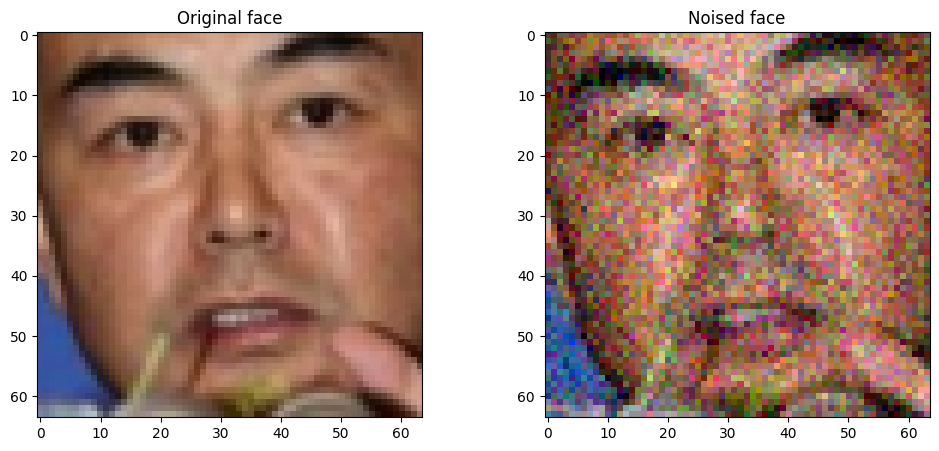

In [ ]:
image = valid_sampler_true[5] + torch.randn_like(train_sampler_true[0])*0.1

noised = image.permute(1, 2, 0).cpu().numpy()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(valid_sampler_true[5].permute(1,2,0).cpu().numpy())
plt.title('Original face')

plt.subplot(1, 2, 2)
plt.imshow(noised)
plt.title('Noised face')

plt.show()


Let us predict the face in this noisy image

<ipython-input-31-8567fda1f82f>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_data = torch.tensor(image, dtype=torch.float)


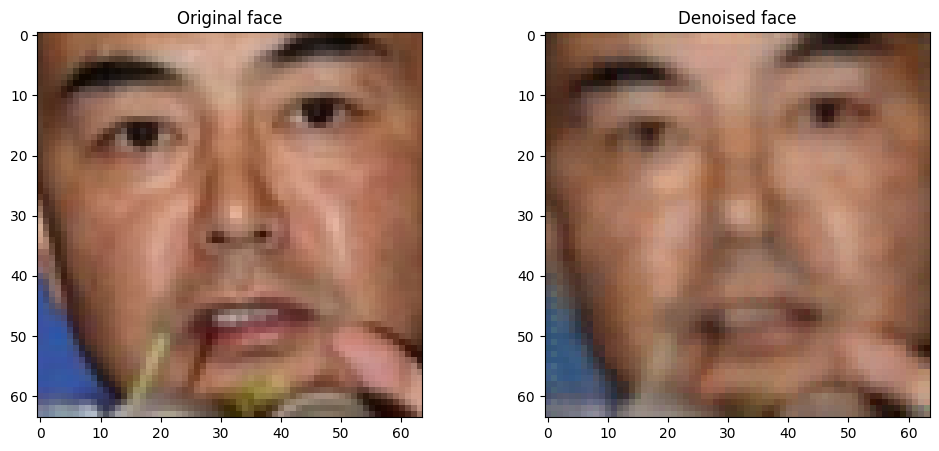

In [ ]:
image = image.to(device)
input_data = torch.tensor(image, dtype=torch.float)
predicted = model(model(input_data))
denoised = predicted.permute(1, 2, 0).cpu().detach().numpy()  # Assuming channels are in the first dimension

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(valid_sampler_true[5].permute(1,2,0).cpu().numpy())
plt.title('Original face')

plt.subplot(1, 2, 2)
plt.imshow(denoised)
plt.title('Denoised face')

plt.show()

we can see an improvement in this image. The result could be very interesting for several iterations.

For evaluate the power of this model, we will use 3 metrics:
* Mean Square Error (MSE): More the MSE is low, best is the model
* Structure Similarity Index (SSI): it evaluates the structural similarity between the original image and the denoised image. It takes into account luminance, contrast and structure. An SSI value closer to 1 indicates better performance.
* Peak Signal-to-Noise Ratio (PSNR): A hight value of PSNR illustrates a good quality of this image

In [ ]:
import torch
import torch.nn.functional as F
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

model.eval()

psnr_values = []
ssim_values = []
mse_values = []

for original_image in test_loader_true:
    noisy_image = original_image + torch.randn_like(original_image) * 0.1

    original_image, noisy_image = original_image.to(device), noisy_image.to(device)

    with torch.no_grad():
        denoised_image = model(noisy_image)

    psnr = peak_signal_noise_ratio(original_image.cpu().numpy(), denoised_image.cpu().numpy())
    ssim = structural_similarity(original_image.permute(0, 2, 3, 1).cpu().numpy(),
                                  denoised_image.permute(0, 2, 3, 1).cpu().numpy(), multichannel=True)
    mse = F.mse_loss(denoised_image, original_image).item()

    psnr_values.append(psnr)
    ssim_values.append(ssim)
    mse_values.append(mse)

average_psnr = np.mean(psnr_values)
average_ssim = np.mean(ssim_values)
average_mse = np.mean(mse_values)

print(f"Average PSNR: {average_psnr:.2f} dB")
print(f"Average SSIM: {average_ssim:.4f}")
print(f"Average MSE: {average_mse:.4f}")



<ipython-input-91-5ad23f9c0e32>:20: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = structural_similarity(original_image.permute(0, 2, 3, 1).cpu().numpy(),


Average PSNR: 28.13 dB
Average SSIM: 0.9671
Average MSE: 0.0015


So, for the test set, we have the following metrics

<table>
  <tr>
    <td>
      METRIC
    </td>
    <td>
      VALUE
    </td>
  </tr>
  <tr>
    <td>
      Average PSNR
    </td>
    <td>
      28.13dB
    </td>
  </tr>
  <tr>
    <td>
      Average SSIM
    </td>
    <td>
      0.9671
    </td>
  </tr>
  <tr>
    <td>
      Average MSE
    </td>
    <td>
      0.0015
    </td>
  </tr>
</table>



So, As the average of PNSR is greater than 25dB, in mean, the quality of predicted image of test set is good.

The indice of simillary is 96%, then in mean, the model produce an image simillar with the original image.

And finally, MSE is very small and acceptable

# 4 - References

[1] https://pytorch.org/docs/stable/index.html

[2] https://kili-technology.com/data-labeling/machine-learning/mean-average-precision-map-a-complete-guide

[3] https://conradsanderson.id.au/lfwcrop/
